device: cuda
Original 9550 samples reduced to 9535 (excluding invalid).
Original 1151 samples reduced to 1149 (excluding invalid).
Train samples: 9535
Val samples: 1149

✅ 전처리 및 데이터 로드 완료 (OpenCV + Albumentations).

Epoch 1/10
------------------------------


Training: 100%|██████████| 298/298 [01:07<00:00,  4.39it/s]


Train Loss: 0.1433 Acc: 0.9445


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.39it/s]


Val  Loss: 0.2042 Acc: 0.9339
>> best model updated

Epoch 2/10
------------------------------


Training: 100%|██████████| 298/298 [00:36<00:00,  8.25it/s]


Train Loss: 0.0560 Acc: 0.9802


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.67it/s]


Val  Loss: 0.0830 Acc: 0.9739
>> best model updated

Epoch 3/10
------------------------------


Training: 100%|██████████| 298/298 [00:35<00:00,  8.34it/s]


Train Loss: 0.0329 Acc: 0.9901


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.52it/s]


Val  Loss: 0.0856 Acc: 0.9730

Epoch 4/10
------------------------------


Training: 100%|██████████| 298/298 [00:36<00:00,  8.10it/s]


Train Loss: 0.0227 Acc: 0.9927


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.31it/s]


Val  Loss: 0.1798 Acc: 0.9478

Epoch 5/10
------------------------------


Training: 100%|██████████| 298/298 [00:36<00:00,  8.07it/s]


Train Loss: 0.0202 Acc: 0.9922


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Val  Loss: 0.1616 Acc: 0.9565

Epoch 6/10
------------------------------


Training: 100%|██████████| 298/298 [00:37<00:00,  7.91it/s]


Train Loss: 0.0142 Acc: 0.9952


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.61it/s]


Val  Loss: 0.2277 Acc: 0.9530

Epoch 7/10
------------------------------


Training: 100%|██████████| 298/298 [00:36<00:00,  8.18it/s]


Train Loss: 0.0215 Acc: 0.9921


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.49it/s]


Val  Loss: 0.1260 Acc: 0.9713

Epoch 8/10
------------------------------


Training: 100%|██████████| 298/298 [00:36<00:00,  8.09it/s]


Train Loss: 0.0125 Acc: 0.9951


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.62it/s]


Val  Loss: 0.1352 Acc: 0.9730

Epoch 9/10
------------------------------


Training: 100%|██████████| 298/298 [00:35<00:00,  8.30it/s]


Train Loss: 0.0130 Acc: 0.9956


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.58it/s]


Val  Loss: 0.1248 Acc: 0.9713

Epoch 10/10
------------------------------


Training: 100%|██████████| 298/298 [00:36<00:00,  8.21it/s]


Train Loss: 0.0070 Acc: 0.9974


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.62it/s]


Val  Loss: 0.1791 Acc: 0.9582

Best val Acc: 0.9739


Measuring Inference Time: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]



평균 배치 추론 시간 (GPU): 0.007780초
FPS (초당 배치 처리량): 128.54 배치/초


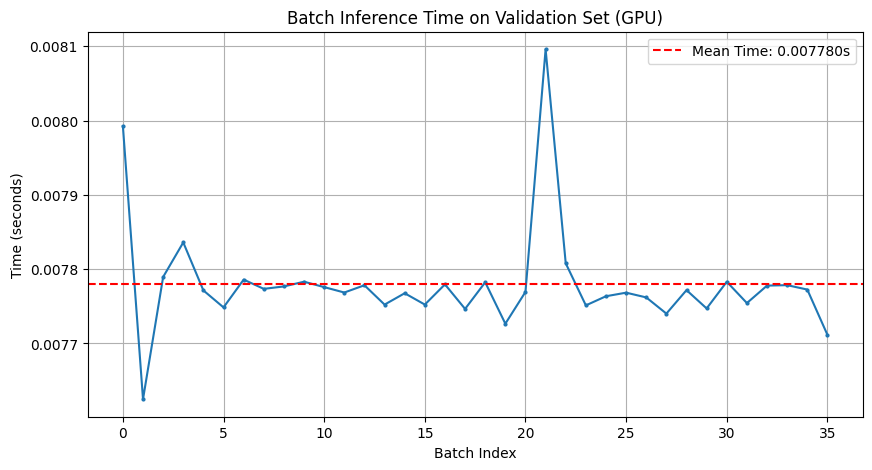


=== Val Metrics (binary: 1=HAPPY, 0=OTHERS) ===
Accuracy : 0.9739
Precision: 0.9353
Recall   : 0.9666
F1-score : 0.9507

Confusion Matrix (rows: true, cols: pred)
[[830  20]
 [ 10 289]]

Classification report:
              precision    recall  f1-score   support

      OTHERS       0.99      0.98      0.98       850
       HAPPY       0.94      0.97      0.95       299

    accuracy                           0.97      1149
   macro avg       0.96      0.97      0.97      1149
weighted avg       0.97      0.97      0.97      1149



In [1]:
import os
import json
import random
import numpy as np
import cv2 # OpenCV 임포트

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from tqdm import tqdm
import copy
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # ToTensorV2 임포트

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import time
import matplotlib.pyplot as plt # 시각화를 위한 pyplot 임포트

# ================================
# 1. 설정 및 시드 고정
# ================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ================================
# 2. Transform 정의 (Albumentations)
# ================================
# ResNet 기본 입력 크기 224x224 기준
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2(),
])

# ================================
# 3. Custom Dataset 정의 및 데이터 로드
# ================================
data_root = "/workspace/user4/cropped"
target_classes = ["anger", "happy", "panic", "sadness"]

train_full_dataset = datasets.ImageFolder(os.path.join(data_root, "train"), transform=None)
val_full_dataset = datasets.ImageFolder(os.path.join(data_root, "val"), transform=None)


def filter_and_remap_dataset(full_dataset, transform, target_classes):
    
    # 0: OTHERS (anger, panic, sadness), 1: HAPPY
    new_samples = []
    for path, class_idx in full_dataset.samples:
        class_name = full_dataset.classes[class_idx]
        
        if class_name not in target_classes:
            continue
            
        if class_name == "happy":
            binary_label = 1 # HAPPY
        else:
            binary_label = 0 # OTHERS
            
        new_samples.append((path, binary_label))
        
    class CustomBinaryDataset(Dataset):
        def __init__(self, samples, transform):
            self.samples = samples
            self.transform = transform
            
        def __len__(self):
            return len(self.samples)
            
        def __getitem__(self, idx):
            path, label = self.samples[idx]
            
            # OpenCV로 이미지 로드 (BGR)
            image = cv2.imread(path)
            
            if image is None:
                 raise FileNotFoundError(f"Image not found or invalid: {path}")

            # BGR -> RGB 변환 (Albumentations는 RGB 입력 기대)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform is not None:
                # Albumentations 적용
                augmented = self.transform(image=image)
                image = augmented['image']
            
            return image, torch.tensor(label, dtype=torch.long)

    print(f"Original {len(full_dataset)} samples reduced to {len(new_samples)} (excluding invalid).")
    return CustomBinaryDataset(new_samples, transform) 


train_dataset = filter_and_remap_dataset(train_full_dataset, train_transform, target_classes) 
val_dataset = filter_and_remap_dataset(val_full_dataset, val_transform, target_classes) 


batch_size = 32
num_workers = 2 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print("\n✅ 전처리 및 데이터 로드 완료 (OpenCV + Albumentations).")

# ================================
# 4. 모델 정의 및 설정 (ResNet18, 2-class)
# ================================
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# 마지막 fc를 2클래스로 교체 (HAPPY vs OTHERS)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)


# ================================
# 5. 학습 함수
# ================================
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # ---- Train ----
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.inference_mode():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_corrects.double() / val_total
        print(f"Val  Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # best model 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, "best_resnet_happy_vs_others.pth")
            print(">> best model updated")

    print(f"\nBest val Acc: {best_val_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model


# ================================
# 6. 학습 실행
# ================================
num_epochs = 10
model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)

# ---
# ================================
# 7. Validation 추론 속도 측정 및 시각화 (추가된 부분)
# ================================
model.eval()
inference_times = [] # 배치당 추론 시간 저장

# GPU 타이머 이벤트 설정
if torch.cuda.is_available():
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    
    # GPU 웜업 (필수)
    dummy_input = torch.randn(batch_size, 3, 224, 224).to(device)
    for _ in range(10):
        _ = model(dummy_input)

    # 실제 측정
    with torch.inference_mode():
        for inputs, _ in tqdm(val_loader, desc="Measuring Inference Time"):
            inputs = inputs.to(device)
            
            starter.record()
            _ = model(inputs)
            ender.record()
            
            # GPU가 완료될 때까지 대기
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender) / 1000.0 # 밀리초(ms) -> 초(s) 변환
            inference_times.append(curr_time)

    mean_inference_time = np.mean(inference_times)
    
    print(f"\n평균 배치 추론 시간 (GPU): {mean_inference_time:.6f}초")
    print(f"FPS (초당 배치 처리량): {1.0 / mean_inference_time:.2f} 배치/초")

    # 시각화 (추론 시간 분포)
    plt.figure(figsize=(10, 5))
    plt.plot(inference_times, marker='o', linestyle='-', markersize=2)
    plt.title(f'Batch Inference Time on Validation Set (GPU)')
    plt.xlabel('Batch Index')
    plt.ylabel('Time (seconds)')
    plt.axhline(mean_inference_time, color='r', linestyle='--', label=f'Mean Time: {mean_inference_time:.6f}s')
    plt.legend()
    plt.grid(True)
    plt.show()

else: # CPU 환경
    print("\nCUDA를 사용할 수 없습니다. CPU 추론 시간을 측정합니다.")
    # CPU 웜업
    for _ in range(10): 
        dummy_input = torch.randn(batch_size, 3, 224, 224).to(device)
        _ = model(dummy_input)

    with torch.inference_mode():
        for inputs, _ in tqdm(val_loader, desc="Measuring Inference Time"):
            inputs = inputs.to(device)
            
            start_time = time.time()
            _ = model(inputs)
            end_time = time.time()
            
            curr_time = end_time - start_time
            inference_times.append(curr_time)

    mean_inference_time = np.mean(inference_times)

    print(f"\n평균 배치 추론 시간 (CPU): {mean_inference_time:.6f}초")
    print(f"FPS (초당 배치 처리량): {1.0 / mean_inference_time:.2f} 배치/초")
    
    # 시각화 (추론 시간 분포)
    plt.figure(figsize=(10, 5))
    plt.plot(inference_times, marker='o', linestyle='-', markersize=2)
    plt.title(f'Batch Inference Time on Validation Set (CPU)')
    plt.xlabel('Batch Index')
    plt.ylabel('Time (seconds)')
    plt.axhline(mean_inference_time, color='r', linestyle='--', label=f'Mean Time: {mean_inference_time:.6f}s')
    plt.legend()
    plt.grid(True)
    plt.show()

# ---
# ================================
# 8. 최종 성능 지표 (Confusion Matrix 포함)
# ================================
model.eval()
all_labels = []
all_preds = []

with torch.inference_mode():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

acc  = accuracy_score(all_labels, all_preds)
# pos_label=1은 HAPPY (긍정 클래스)를 기준으로 Precision, Recall, F1-score 계산을 지정합니다.
prec = precision_score(all_labels, all_preds, pos_label=1) 
rec  = recall_score(all_labels, all_preds, pos_label=1)
f1   = f1_score(all_labels, all_preds, pos_label=1)
cm   = confusion_matrix(all_labels, all_preds)

print("\n=== Val Metrics (binary: 1=HAPPY, 0=OTHERS) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print("\nConfusion Matrix (rows: true, cols: pred)")
print(cm)

print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=["OTHERS", "HAPPY"]))